## Survival Forest Experiments

In this notebook we try fitting scikit-survival's random survival forest to our data. We first try one-hot encoding all categorical features, and fitting a random forest model on the result. We then try refitting the model, using only features that were identified as important by the original model. In both cases, the model performs comparably to Cox Proportional Hazard models. 

This dataset has many high-cardinality categorical features. Random forest models may struggle to deal with one-hot encoded categorical variables. A split in a decision tree based on a one-hot encoded feature amounts to splitting a category as "one" vs. "rest", which may not be terribly efficient. To address this, we try target encoding categorical variables instead of one-hot encoding. However, this did not improve performance.

While we may be able to do better with hyperparameter tuning, overall random survival forest does not seem very promising for this dataset.

### Load Data, One-Hot Encode Categorical Variables

In [ ]:
# import libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines as lflns
sns.set_style('whitegrid')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

from sksurv.ensemble import RandomSurvivalForest

In [2]:
# Load training data
hct_df = pd.read_csv("../data/train_set.csv")

# Replace text value that corresponding so missing data with NaN
hct_df = hct_df.replace(to_replace=["Missing Disease Status", "Missing disease status"], value=np.nan)

# drop year column, which isn't appropriate for prediction
hct_df = hct_df.drop(columns=['year_hct'])

In [3]:
# Use one-hot encoding to encode categorical columns.
# The min_frequency option will bin very rare values
# of each categorical variable into a new
# 'infrequent' category.
# The minimum frequency of 0.001 corresponds to a 
# minimum of roughly 20 training samples.

cat_cols = list(hct_df.select_dtypes(include='O').columns)

encoder = ColumnTransformer(
    [
        ('one_hot', 
         OneHotEncoder(drop='first', 
                       min_frequency=0.001, 
                       handle_unknown='ignore',
                       ), 
        cat_cols
        ),
    ],
    sparse_threshold=0,
    remainder='passthrough',
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
    )

# Drop the ID column, which should not be used
# in prediction.
# We keep it in hct_df above, because it may 
# be needed for the custom score function.
df_enc = pd.DataFrame(encoder.fit_transform(hct_df), columns=encoder.get_feature_names_out()).drop("ID", axis=1)

### Random Forest Model with One-Hot Encoded Features

In [4]:
from sksurv.util import Surv

# Encode targets in a way that is compatible with scikit-survival
outcomes = Surv.from_arrays(event = df_enc['efs'].astype('bool'), time = df_enc['efs_time'])

# Create dataframe of features
feat_names = df_enc.columns[:-2]
features = df_enc[feat_names]

In [5]:
# Split training data further into test and train,
# to get a first pass at seeing how well the model generalizes
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, outcomes, shuffle=True)

In [6]:
# When I tried running the survival forest out of the box,
# I kept running into memory errors. 
# For this reason, I'm adding value of max_depth,
# which controls the depth of individual decision trees
# and creates a simpler model.
rsf = RandomSurvivalForest(max_depth=10, n_jobs=-1, low_memory=True)

In [7]:
rsf.fit(X_train, y_train)

RandomSurvivalForest(low_memory=True, max_depth=10, n_jobs=-1)

In [8]:
rsf.score(X_test, y_test)

np.float64(0.6487173530675555)

#### Examine Feature Importances, Refit Model with Most Important Features

In [9]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test, y_test, n_repeats=5, random_state=47)

In [10]:
importances = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

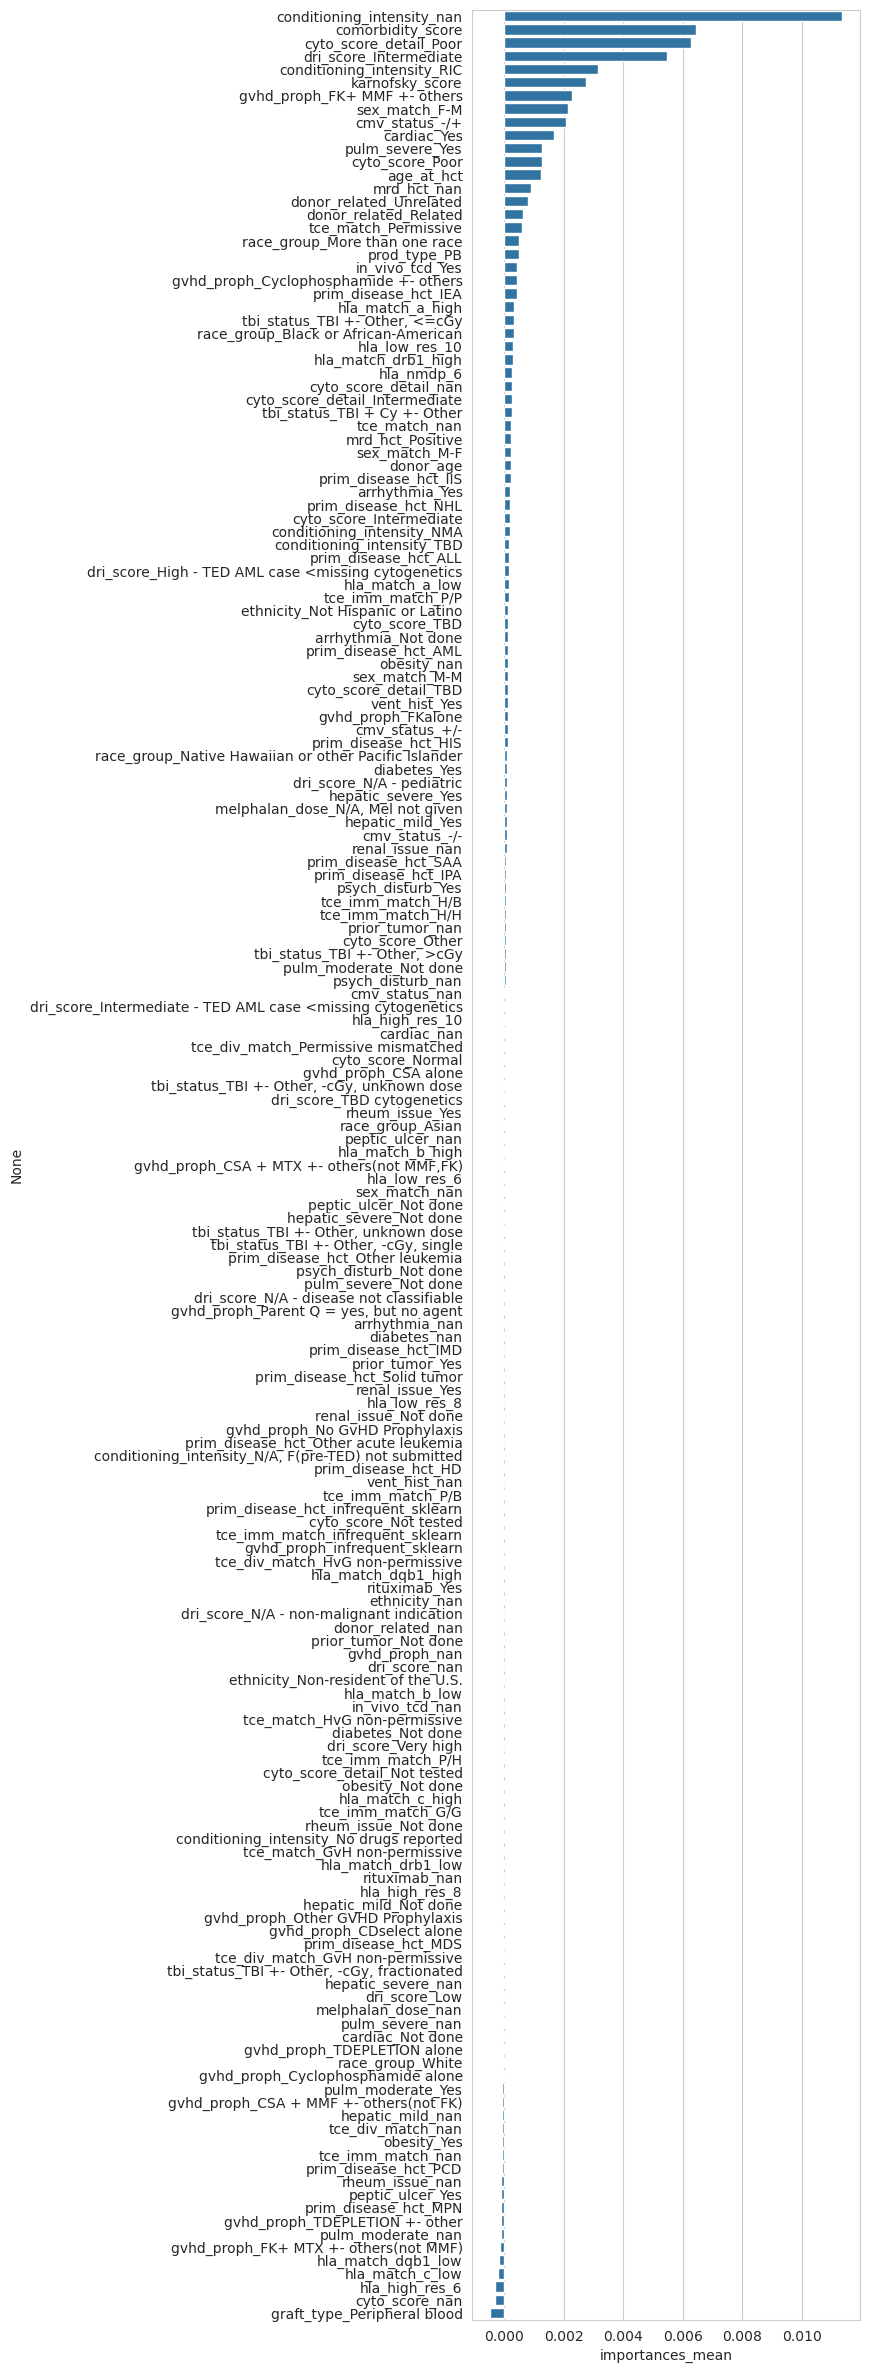

In [11]:
import seaborn as sns
plt.figure(figsize=(5, 30))
sns.barplot(x = importances['importances_mean'], y=importances.index)
plt.show()

In [12]:
# Take the top 20% of features by importance
top_importances = importances.iloc[0:35, :]
top_feature_names = top_importances.index.to_list()

In [13]:
top_features = df_enc[top_feature_names]

In [14]:
rsf2 = RandomSurvivalForest(max_depth=20, n_jobs=-1, low_memory=True)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(top_features, outcomes)

In [16]:
rsf2.fit(X_train, y_train)

RandomSurvivalForest(low_memory=True, max_depth=20, n_jobs=-1)

In [17]:
rsf2.score(X_test, y_test)

np.float64(0.6538706227312864)

In [18]:
result = permutation_importance(rsf2, X_test, y_test, n_repeats=5, random_state=47)

In [19]:
importances = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

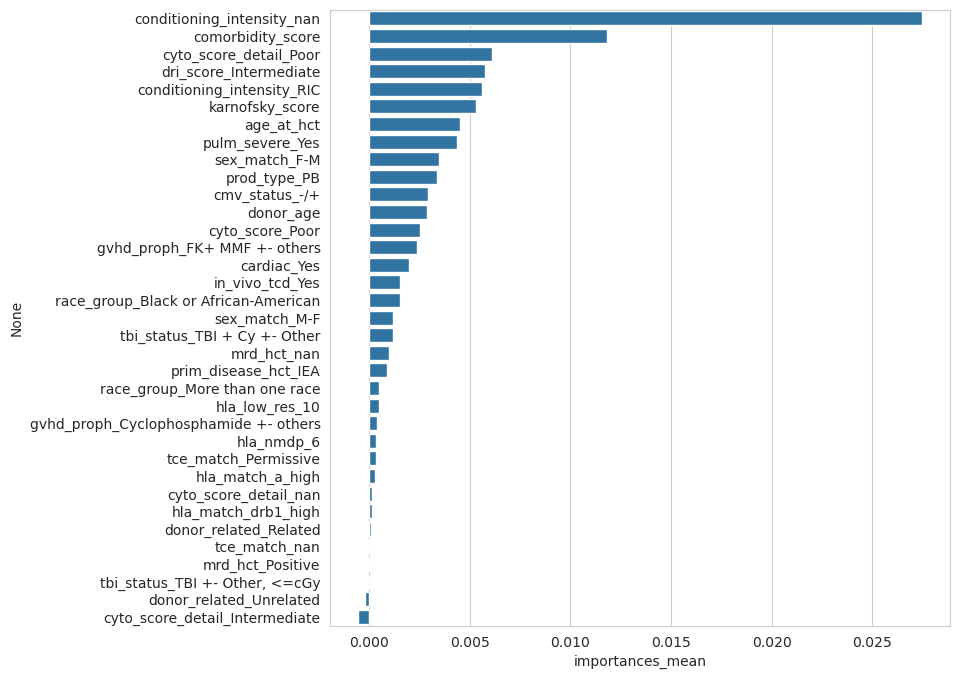

In [20]:
plt.figure(figsize=(8, 8))
sns.barplot(data=importances, y=importances.index, x='importances_mean')
plt.show()

### Target Encode Categorical Variables

In [ ]:
from sklearn.preprocessing import TargetEncoder

cat_cols = list(hct_df.select_dtypes(include='O').columns)

encoder = ColumnTransformer(
    [
        ('target', 
         TargetEncoder(), 
        cat_cols
        ),
    ],
    sparse_threshold=0,
    remainder='passthrough',
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
)


In [22]:
train, test = train_test_split(hct_df)

In [23]:
features_train_raw = train.iloc[:, :-2].drop("ID", axis=1)
train_target = train['efs_time']
train_outcomes = Surv.from_dataframe(data=train, event='efs', time='efs_time')

In [24]:
features_train_processed = pd.DataFrame(encoder.fit_transform(features_train_raw, train_target), columns=encoder.get_feature_names_out())

### Random Forest Model with Target-Encoded Variables

In [25]:
rsf = RandomSurvivalForest(max_depth=20, n_jobs=-1, low_memory=True)

In [26]:
rsf.fit(features_train_processed, train_outcomes)

RandomSurvivalForest(low_memory=True, max_depth=20, n_jobs=-1)

In [27]:
features_test_raw = test.iloc[:, :-2].drop("ID", axis=1)
features_test_processed = pd.DataFrame(encoder.transform(features_test_raw), columns=encoder.get_feature_names_out())
test_outcomes = Surv.from_dataframe(data=test, event='efs', time='efs_time')
rsf.score(features_test_processed, test_outcomes)

np.float64(0.6566001320087791)

In [28]:
result = permutation_importance(rsf, features_test_processed, test_outcomes, n_repeats=5, random_state=47)

In [29]:
importances = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=features_test_processed.columns,
).sort_values(by="importances_mean", ascending=False)

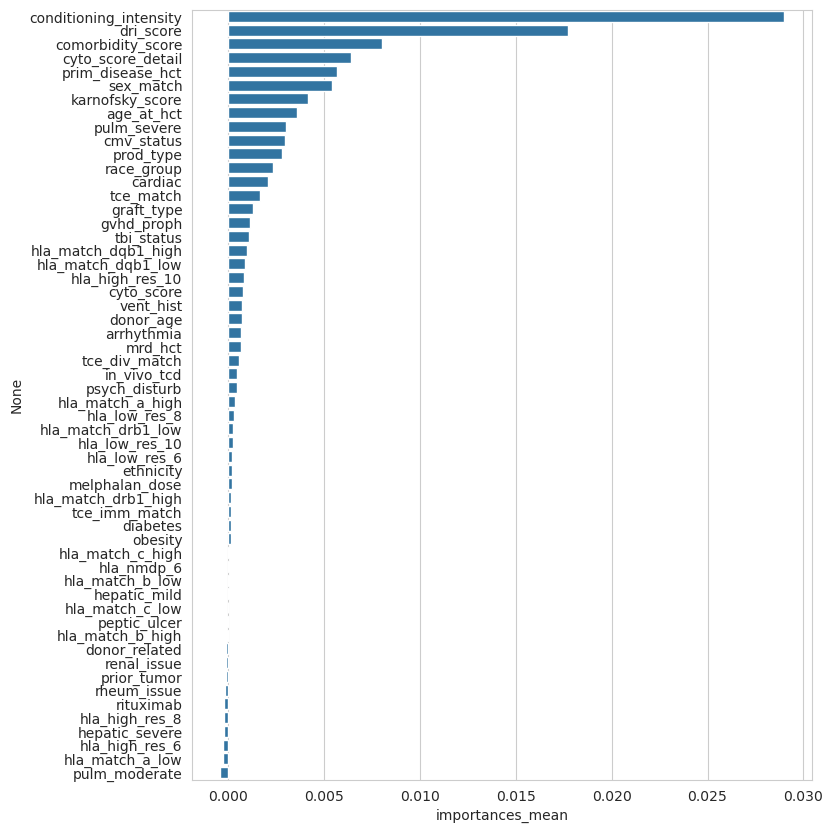

In [30]:
plt.figure(figsize=(8, 10))
sns.barplot(data=importances, y=importances.index, x='importances_mean')
plt.show()